# Instructor version: Wells

### Input files needed:
- topography.csv - array of land surface elevations 
- watershed.csv - array of no-flow cells indicating the watershed boundary

### MODFLOW packages used:
- DIS - Discretization input
- BAS - Basic
- LPF - Layer-Property Flow
- OC  - Output Control
- PCG - Preconditioned Conjugate Gradient
- RCH - Recharge
- STR - Stream
- EVT - Evapotranspiration
- WEL - Wells
    
### Model description:
This is a steady-state model of the watershed shown below.
![conceptual diagram of base model](sketch.jpg) <br>

**Discretization**<br>
The model has 50x50 cells, each measuring 1000 m in x and in y.  <br>
There are two homogeneous, isotropic layers. <br>
The model has a bottom elevation of 0 m (this is the datum elevation) and a top elevation that corresponds to the land surface elevation. <br>
The land surface elevation in meters above the datum (from the topography.csv file). <br>
The boundary between the two layers is flat and is at an elevation of 50 m above the datum. <br>
The origin for model *coordinates* is the bottom southeast corner (lower left). <br>
The origin for model *indexing* is the top northeast corner (upper left). <br>
The code should now correct for this. For reference: Layer 0 is at the top, Layer 1 is at the bottom. Column 0 is the leftmost (westernmost) column, Column 49 is the rightmost (easternmost) column. Row 0 is the uppermost (northermost) row, Row 49 is the lowermost (southernmost) row.

**Aquifer properties** <br>
The porosity is 0.10, specific yield is 0.10, and storage coefficient is 0.0001. <br>
The horizontal hydraulic conductivity was found to be 21.5 m/day through calibration to hydraulic heads in piezometers. <br>
The vertical hydraulic conductivity is 10 m/day. <br>

**Boundaries** <br>
The edges of the watershed are bounded by impermeable bedrock on three sides.  These are represented as no-flow cells (from the watershed.csv file). <br>
The right (eastern) boundary has a constant head of 70 m relative to the datum. <br>

Recharge occurs at a rate of 4E-5 m/day in the leftmost (western) 15 active columns and is zero elsewhere. <br>

A stream runs west to east along row 25, from column 5 to column 49. There are no tributaries contributing surface inflow, but the stream does receive some water from surface runoff. The stream channel is 10 m wide. The streamed sediment is 1 m thick, with a higher hydraulic conductivity than the surrounding aquifer. The roughness is 0.04 and the slope is 0.001. The elevation of the top of the streambed is one meter below the land surface and the stream stage is 0.5 m above the top of the streambed. The stream is a 'weak sink' with a strength of 0.5, meaning that half of the water molecules that enter a stream cell are captured by the stream. 

Water leaves the model through evapotranspiration. ET is relatively low in most of the model. In the riparian zone along the stream, ET is higher. The highest ET rates occur on an irrigated farm field, where ET is 75% of the irrigation rate and recharge is 25% of the irrigation rate (none of the irrigation water runs off). The extinction depth (the maximum depth from which water can evaporate from soil) is 1 m everywhere.

A pumping well is used to irrigate the agricultural field. The pumping rate is equal to the irrigation rate multiplied by the field area.


## Import Python packages

In [1]:
import os
import numpy as np
import numpy.ma as ma
import pandas as pd
import csv                                             
import flopy
import flopy.utils.binaryfile as bf
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## Model setup

In [2]:
##Name:
modelname = "well"

##Grid:
nrow = 50          #number of rows
ncol = 50          #number of columns
delr = 1000.       #width of each cell along rows (so really this is column width along x axis)
delc = 1000.       #width of each cell along columns (so really this is row height along y axis)
Lx = ncol*delr     #width of domain in x (across columns) = number of columns x cell width
Ly = nrow*delc     #width of domain in y (across rows) = number of rows x cell height

##Layers:
nlay = 2                                                #number of layers
layers = np.arange(nlay)                                #make array of layers
ztop = np.genfromtxt('topography.csv', delimiter=',')   #import top elevation of model from csv file (dim: nrow,ncol)
zbot = 0.                                               #bottom elevation of model (datum)
botm = np.full((nlay,nrow,ncol),zbot)                   #make array of default cell bottom elevations for each cell in the model (dim:nlay,nrow,ncol)
botm[0,:,:] = 50.                                       #replace the cell bottom elevations in the top layer (layer 0) with the elevation of the boundary between layers

##Medium properties:
#Hydraulic conductivity:
#Kx and Ky:
K_horiz = 21.5    #horizontal hydraulic conductivity (along rows)
K_ratio = 1.     #ratio of Ky/Kx (aka Kcol/Krow) - if Kx=Ky, ratio=1
#Kz:
K_vert = 10.     #vertical hydraulic conductivity (along z axis)

#Porosity, storage, specific yield, confined/unconfined:
n  = 0.1         #porosity
Ss = 0.0001      #storage coefficient
Sy = 0.1         #specific yield
uncnf = 1        #if 0 then confined, if >0 then unconfined

In [3]:
##Constant head boundary conditions:
#if ibound < 0, constant head; if ibound = 0, inactive/no-flow/outside of watershed; if ibound > 0, active.

#create arrays to indicate active cells and boundary conditions (ibound):
ibound = np.full((nlay,nrow,ncol),0)                            #make array of zeros for default boundary conditions (dim:nlay,nrow,ncol)
ibound[:,:,:] =  np.genfromtxt('watershed.csv', delimiter=',')  #import locations of active and inactive cells from csv (all layers, all rows, all cols)
ibound[:,11:41,ncol-1] = -1                                     #replace rightmost (eastern) column (slice all layers, active rows, last column) with -1 to indicate constant head

#create array of initial head values across the model and at the boundaries
H_init = 70.                                #initial hydraulic head in meters
strt = np.full((nlay, nrow, ncol), H_init)  #float (i.e. decimal) array, sets initial head in all cells to desired value

In [4]:
##Stream (using STR package):
str_lay = 0                          #layer stream is in
str_row = 25                         #row stream is in
start_col = 5                        #column stream starts in
end_col   = 49                       #column stream ends in
nreach = end_col - start_col         #number of stream reaches (i.e. cells) (end col - start col)
nseg = 1                             #number of segments (only applicable if there are tributaries)
segments = np.ones((nreach))      #integer array of segment numbers for each reach
str_rows = np.full((nreach), str_row)            #integer array of row #s for each reach 
str_cols = np.arange(start_col, end_col)         #integer array of col #s for each reach 

inflow = 4000.                       #inflow to each stream reach (m3/day)
stage = 0.5                          #stage of stream (height above top of streambed in m)
Kstream = 173.                       #K of streambed (m/day)
width = 10.                          #x-sectional width of channel (m)
slope = 0.001                        #slope of streambed (m/m)
rough = 0.04                         #roughness of streambed
thickness = 1.                       #thickess of streambed sediment (m)

icalc = 0                            #0 = fixed stage, >0 = calculated stage
const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
istcb2 = 53                          #save outflows to cbb file

#Calculate streambed elevations:
surf_elev = np.zeros((nreach))       #create array of zeros the length of the stream
for i in np.arange(nreach):                       #iterate over stream reaches
    surf_elev[i] = ztop[str_rows[i],str_cols[i]]  #get land surface elevation from ztop for each stream cell

str_top = surf_elev - 1            #elevation of the top of the streambed (1 m below land surface) (m)
str_bot = str_top - thickness      #elevation of the bottom of the streambed (m)
stage_elev = str_top + stage       #elevation of the water surface in the stream with respect to model datum (m)
    
#Create FloPy input dictionaries:
str_info = np.zeros((nreach,13))   #create array of zeros for reaches with 13 slots (one per variable)
for i in np.arange(nreach):        #iterate over reaches
    #create stream info array: [lay, row, col, seg, reach, flow, stage, cond, sbot, stop, width, slope, rough]
    str_info[i,:] = [str_lay, str_rows[i], str_cols[i], segments[i], i, inflow, stage_elev[i], Kstream, str_bot[i], str_top[i], width, slope, rough]

str_spd = {0: str_info}                        #create dictionary of stream info keyed to stress periods
seg_info = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   #create segment info array - all zeros since only one segment
str_segd = {0: seg_info}                       #create dict of segment info keyed to stress periods

In [5]:
##ET:
ET_surf = ztop                                            #set ET surface (elev at which max ET occurs - default to land surface)
extinction_depth = np.full((nrow,ncol), 1.0)              #create array and assign extinction depth to all cells in top layer

ET_default = 1e-5                                         #ET rate in most of model (grassland) [m/day]
ET_riparian = 3e-5                                        #ET rate in riparian zone (gallery forest) [m/day]
Irr = 5e-4                                                #Irrigation rate for ag field [m/day]
ET_ag = 0.75 * Irr                                        #ET rate in ag field [m/day] = 75% of irrigation rate

ET = np.full((nrow,ncol), ET_default)                     #define an array of default ET rate the size of the 2D model grid (2D because ET only occurs in top layer)
ET[str_row-5:str_row+6, start_col:end_col] = ET_riparian  #assign riparian ET rate to cells on either side of stream
ET[30:35,20:25] = ET_ag                                   #set ag ET rate in columns and rows representing ag field
n_agcells = np.count_nonzero(ET[ET==ET_ag])               #count number of cells in which the value of ET is the ag ET rate - this is the number of cells in the ag field

In [6]:
## Recharge conditions:
R = 4e-5                              #recharge rate in hills [m/day]
rech = np.zeros((nrow,ncol))          #make array of zeros for recharge (dim: nrow, ncol, no layers because recharge only happens in top layer)
rech[:,0:15] = R                      #set recharge in the leftmost 15 columns to the desired recharge rate

R_ag = 0.25 * Irr                     #calculate recharge rate in ag field based on irrigation rate [m/day]
rech[30:35,20:25] = R_ag              #assign ag recharge rate to cells representing ag field

In [7]:
##Wells:
well_loc = [0,32,22]         #well location: [lay, row, col]
Qwell = -Irr * n_agcells * 1000 * 1000   #well pumping rate (m3/day) = irrigation rate x field surface area. Negative because well is removing water from aquifer (an injection well would be positive)
well_loc2 = [0,32,35]        #add a second well location
Qwell2 = -12000.             #second well pumping rate
well_info = [[well_loc[0],well_loc[1],well_loc[2], Qwell],
             [well_loc2[0],well_loc2[1],well_loc2[2], Qwell2]]          #well info: [lay, row, col, pumping rate] (correct for flipped origin)

well_spd = {0: well_info}    #create a dictionary with entries for each stress period

In [8]:
##Manual estimates: how much water should enter as recharge or leave as ET?
print('recharge cells', ibound[0,:,0:15].sum())
rh = R*ibound[0,:,0:15].sum()*delr*delc
print('recharge total in hills', rh, 'm3/day')

print('ag cells', n_agcells)
ra = 0.25 * Irr * n_agcells * delr * delc
print('recharge total in ag field', ra, 'm3/day')
print('total recharge', rh+ra, 'm3/day\n')


print('ET cells', np.count_nonzero(ET[ET==ET_riparian]))
eh = ET_riparian*np.count_nonzero(ET[ET==ET_riparian])*delr*delc
print('ET total in riparian zone', eh, 'm3/day')

ea = 0.75 * Irr * n_agcells * delr * delc
print('max ET total in ag field', ea, 'm3/day')
print('max total ET', eh+ea, 'm3/day')

recharge cells 353
recharge total in hills 14120.000000000002 m3/day
ag cells 25
recharge total in ag field 3125.0 m3/day
total recharge 17245.0 m3/day

ET cells 479
ET total in riparian zone 14370.000000000002 m3/day
max ET total in ag field 9375.0 m3/day
max total ET 23745.0 m3/day


In [9]:
##Outputs:
#this section usually does not change - we are telling the model which outputs to print

oc_spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...']
ipakcb = 53    #unit to save cell-by-cell outputs to

In [10]:
#Create the model objects and the objects for each package
#Note: running this section multiple times without changing filenames (see block above) will overwrite the existing 
#files & generate a warning that existing packages are being replaced. This is fine.

#Create model object:
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')    #MODFLOW executable must be in same folder, named mf2005.exe
    
#Create objects for each package (see GHW1 notebook for details):
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, 
                               delc=delc, top=ztop, botm=botm)         #DIS (Discretization): creates model grid   
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)           #BAS (Basic): assigns head boundaries
lpf = flopy.modflow.ModflowLpf(mf, laytyp=uncnf, chani=0, hk=K_horiz, hani=K_ratio, vka=K_vert, 
        ss=Ss, sy=Sy, storagecoefficient=False, ipakcb=ipakcb)            #LPF (Layer Property Flow): assigns flow props between cells
oc = flopy.modflow.ModflowOc(mf, stress_period_data=oc_spd, compact=True) #OC (Output Control): Decides what outputs to save
pcg = flopy.modflow.ModflowPcg(mf)                                        #PCG (Preconditioned Conjugate Gradient)
rch = flopy.modflow.mfrch.ModflowRch(mf, rech=rech)                       #RCH (Recharge)
strm = flopy.modflow.mfstr.ModflowStr(mf, mxacts=nreach, nss=nseg, ntrib=0, ndiv=0,icalc=icalc, const=const, ipakcb=ipakcb,  istcb2=istcb2, dtype=None,
        stress_period_data=str_spd, segment_data=str_segd, extension='str')  #STR (Stream)
evt = flopy.modflow.mfevt.ModflowEvt(mf, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53)  #EVT (Evapotranspiration) - note: your computer may try to read this as an event log file
wel = flopy.modflow.mfwel.ModflowWel(mf, stress_period_data=well_spd)     #WEL (Well)  

### Display summary of model inputs

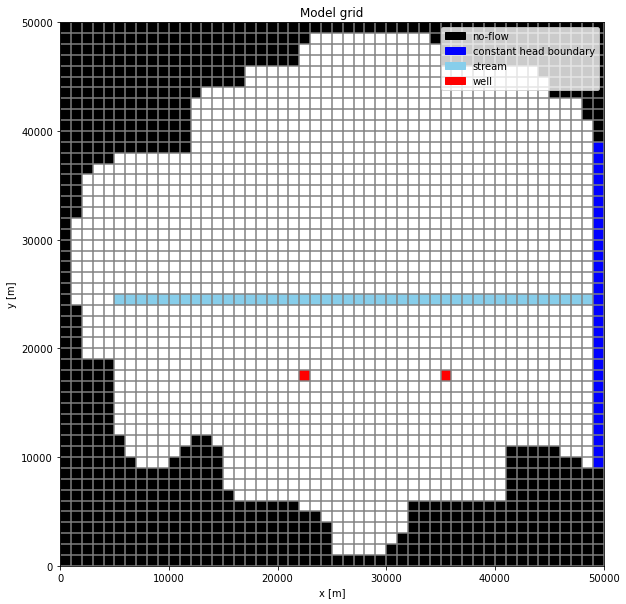

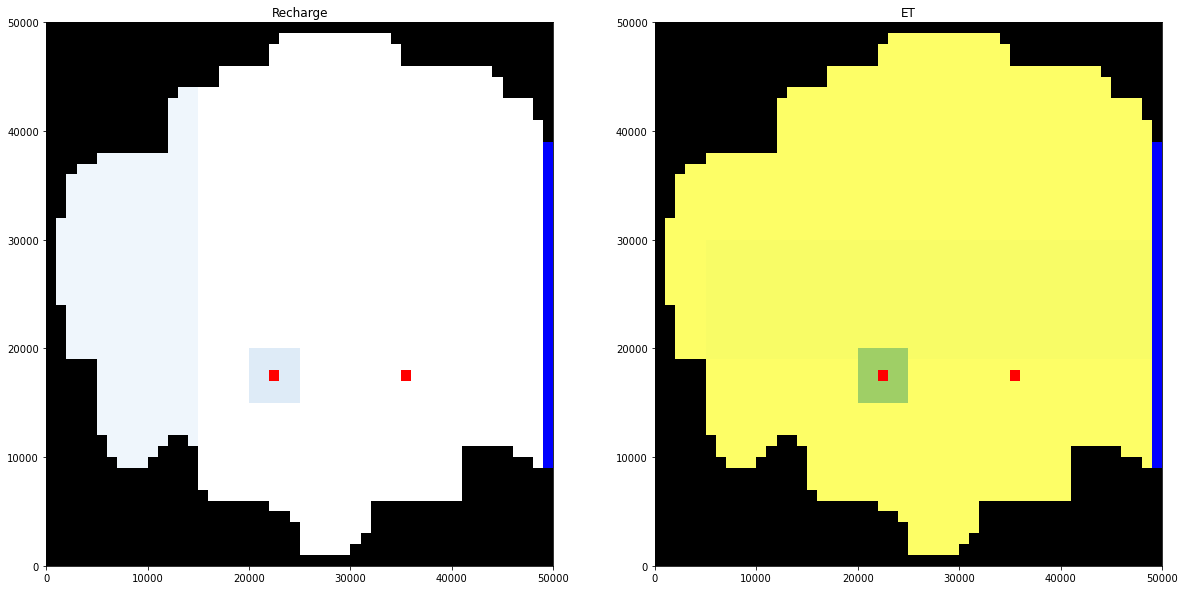

In [11]:
#Plot model grid:
f,ax = plt.subplots(1,1,figsize=(10,10))                    #create new figure and axes
plt.title('Model grid')                                     #set figure title
m = flopy.plot.PlotMapView(model=mf, layer=0)               #create model map object
grid = m.plot_grid(colors='gray')                           #plot model grid
bc = m.plot_ibound()                                        #plot boundary conditions
s = m.plot_bc("STR", color='skyblue')                       #plot stream
w = m.plot_bc("WEL", color='red')                           #plot wells
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.legend(handles=[matplotlib.patches.Patch(color='black',label='no-flow'),      #add legend manually
                    matplotlib.patches.Patch(color='blue',label='constant head boundary'),
                    matplotlib.patches.Patch(color='skyblue', label='stream'),
                    matplotlib.patches.Patch(color='red', label='well')])

f,ax = plt.subplots(1,2,figsize=(20,10))                    #create new figure and axes with two subplots
ax[0].set_title('Recharge')                                 #set first subplot title
m = flopy.plot.PlotMapView(model=mf, ax=ax[0], layer=0)     #create model map object on first subplot axes
rech_mx = ma.masked_values (rech, 0)                        #make a masked head array where all cells with no recharge are hidden
r = m.plot_array(rech_mx, cmap='Blues', vmin=0,vmax=0.001)  #plot recharge array
w = m.plot_bc("WEL", color='red')                           #plot wells
bc = m.plot_ibound()                                        #plot boundary conditions

m = flopy.plot.PlotMapView(model=mf, ax=ax[1], layer=0)     #create model map object on second subplot axes
ax[1].set_title('ET')                                 #set first subplot title
ET_mx = ma.masked_values (ET, 0)                            #make a masked head array where all cells with no ET are hidden
et = m.plot_array(ET_mx, cmap='summer_r', vmin=0,vmax=0.001)  #plot ET array
w = m.plot_bc("WEL", color='red')                           #plot wells
bc = m.plot_ibound()                                        #plot boundary conditions

Text(0.5, 1.0, 'west-east cross-section')

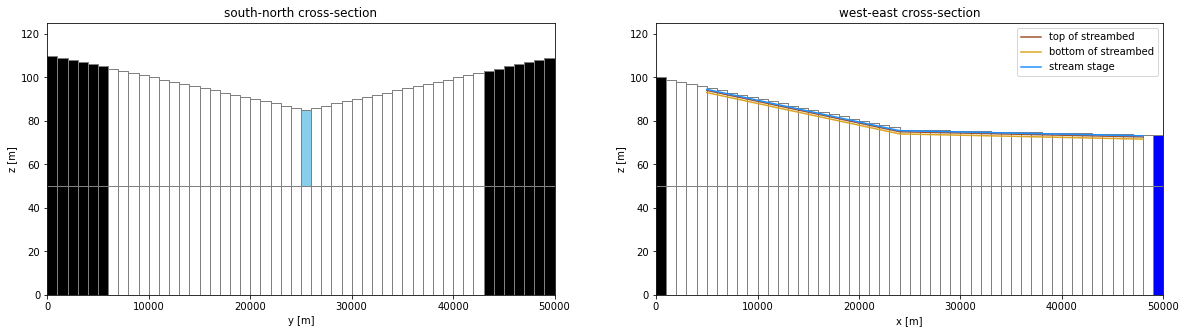

In [12]:
#Plot cross-section view of model:

#South-North:
f,ax = plt.subplots(1,2, figsize=(20,5))                                     #create empty figure and axes objects
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'Column': 15})   #plot cross-section along given column (change column # to see different locations)
bc = xsec.plot_ibound()                                                      #plot boundary conditions
s  = xsec.plot_bc("STR", color='skyblue')                                    #plot stream
g  = xsec.plot_grid()                                                        #plot model grid
ax[0].set_xlabel('y [m]')
ax[0].set_ylabel('z [m]')
ax[0].set_title('south-north cross-section')

#East-West:
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': str_row})    #plot cross-ection along stream row
bc = xsec.plot_ibound()                                                         #plot boundary conditions
g  = xsec.plot_grid()                                                           #plot grid
st = ax[1].plot(str_cols*delc, str_top, c='sienna')                             #plot streambed top
sb = ax[1].plot(str_cols*delc, str_bot, c='goldenrod')                          #plot streambed top
sg = ax[1].plot(str_cols*delc, stage_elev, c='dodgerblue')                      #plot streambed top

plt.legend(handles=[matplotlib.lines.Line2D([],[], color='sienna', label='top of streambed'),
                    matplotlib.lines.Line2D([],[], color='goldenrod', label='bottom of streambed'),
                    matplotlib.lines.Line2D([],[], color='dodgerblue', label='stream stage'),]) #add legend manually
ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('z [m]')
ax[1].set_title('west-east cross-section')

## Run model
The code in this section will change very little other than adding packages

In [13]:
#Write MODFLOW input files:
mf.write_input()

#Run MODFLOW:
success, buff = mf.run_model()                 #you should see "normal termination of simulation" printed below

FloPy is using the following executable to run the model: .\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: well.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/03/08 13:53:18

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/03/08 13:53:18
 Elapsed run time:  0.110 Seconds

  Normal termination of simulation


In [14]:
#Run MODPATH for particle tracking:
mp = flopy.modpath.Modpath6(modelname=modelname+'_mp', exe_name='mp6.exe', 
        modflowmodel=mf, model_ws=None, dis_file=modelname+'.dis', 
        head_file=modelname+'.hds', budget_file=modelname+'.cbc')                 #create MODPATH model object
mpb = flopy.modpath.Modpath6Bas(mp, hdry=mf.lpf.hdry, laytyp=mf.lpf.laytyp, 
        ibound=ibound, prsity=n)                                                  #create MODPATH BAS object
sim = mp.create_mpsim(trackdir='forward', simtype='pathline', packages='RCH')     #create MODPATH simulation

mp.write_input()                 #write MODPATH input files
mp.run_model(silent=False)       #run MODPATH - you should see "Normal termination" printed below

FloPy is using the following executable to run the model: .\mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00                                                                       
Particle tracking complete. Writing endpoint file ...                                                                               
End of MODPATH simulation. Normal termination.


(True, [])

## Post-process and display results
Extract the raw output data and convert it into a format that's meaningful for humans

In [15]:
##Get outputs:
#This section usually does not change much

#Get MODFLOW outputs:
hds = bf.HeadFile(modelname+'.hds')    #reads the raw binary head output file 
times = hds.get_times()                #returns a list of timesteps
head = hds.get_data(totim=times[-1])   #returns an array of heads for the specified time (last timestep)
head_mx = ma.masked_values (head, -999.99)  #make a masked head array where all no-flow cells (with the value -999.99) are hidden

#Get cell-by-cell outputs from the cell budget output file:
#string options are in the list file under output control (make sure to include spaces!)
cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells
stf = cbb.get_data(text='STREAM FLOW OUT ', totim=times[-1])[0]     #returns an array of flow rates in stream cells
stl = cbb.get_data(text='  STREAM LEAKAGE', totim=times[-1])[0]     #returns an array of leakage rates in stream cells

#Get MODPATH outputs: 
#load the endpoint data:
endobj = flopy.utils.EndpointFile(mp.sim.endpoint_file)   #get the raw MODPATH endpoint file
ept = endobj.get_alldata()                                 #import the endpoint data to FloPy
#convert ept to an array:
ept_array = np.zeros((len(ept),len(ept[0])-1))             #create an empty array the same dimensions as the ept file
for row in np.arange(len(ept)):                            #loop over the ept file rows
    for col in np.arange(len(ept[0])-1):                   #loop over the ept file columns (except the last one)
        ept_array[row,col] = ept[row][col]                 #assign each ept item to the array
        
#load the pathline data:
pthobj = flopy.utils.PathlineFile(mp.sim.pathline_file)
plines = pthobj.get_alldata()

In [16]:
#Display water budget:

#Get water budget information:
lst = flopy.utils.MfListBudget(modelname+'.list')       #read the list file
budget = lst.get_data()                                 #get cumulative water budget for last timestep
labels = [str(budget[i][2])[2:] for i in np.arange(len(budget))] #get and trim labels for each budget item (one-line for loop)
vals = [budget[i][1] for i in np.arange(len(budget))]   #get values for each budget item

#Print water budget:
print('%25s'%'MASS BALANCE','\n')   #print right-justified header taking up 25 spaces, then go to new line
b=[print("%25s"%labels[i],'\t',"%10s"%vals[i]) for i in np.arange(len(budget))]  #iterate to print each item in buget

#Print timesteps:
print('\ntimesteps:',times)
print('stress periods:', kstpkper_list)

             MASS BALANCE 

              STORAGE_IN' 	        0.0
        CONSTANT_HEAD_IN' 	     3505.3
                WELLS_IN' 	        0.0
                   ET_IN' 	        0.0
             RECHARGE_IN' 	    17245.0
       STREAM_LEAKAGE_IN' 	     4259.5
                TOTAL_IN' 	    25009.8
             STORAGE_OUT' 	       -0.0
       CONSTANT_HEAD_OUT' 	  -509.8001
               WELLS_OUT' 	   -24500.0
                  ET_OUT' 	       -0.0
            RECHARGE_OUT' 	       -0.0
      STREAM_LEAKAGE_OUT' 	       -0.0
               TOTAL_OUT' 	   -25009.8
                  IN-OUT' 	        0.0
     PERCENT_DISCREPANCY' 	        0.0

timesteps: [1.0]
stress periods: [(0, 0)]


In [17]:
#Get hydraulic head at a specific location (the head you would measure if you installed a piezometer there):

lay = 0                     #layer piezometer is in
row = 12                    #row piezometer is in
col = 42                    #column piezometer is in
h = head[lay,row,col]       #head at piezometer location

piezo = np.full((nlay,nrow,ncol), np.nan)  #create array of null values to be able to map piezometer
piezo[lay,row,col] = 1                     #mark the piezometer location with a 1

vmin = head_mx.min()                      #find the lowest head (excluding no-flow cells)
vmax = head_mx.max()                      #find the highest head (excluding no-flow cells)

text = 'Head at layer {}, row {}, col {}: \t{:.3f} m'   #text to print (print last one with only 3 decimal places, add a tab before the last item)
print(text.format(lay,row,col,h))  #print and fill curly brackets above with parameter values

text = 'Min. head: \t\t\t\t{} m \nMax. head: \t\t\t\t{:.3f} m'
print(text.format(vmin,vmax))

Head at layer 0, row 12, col 42: 	70.361 m
Min. head: 				63.8994026184082 m 
Max. head: 				76.211 m


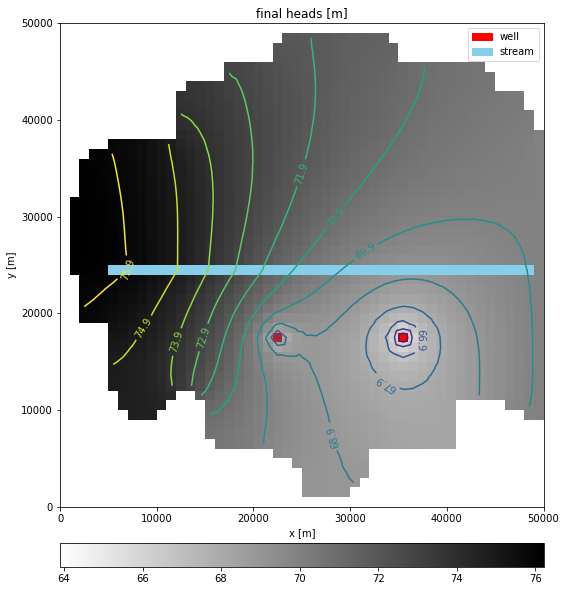

In [18]:
#Plot the hydraulic heads in layer 1 at the end of the model run

f,ax = plt.subplots(1,1, figsize=(10,10))         #create figure and axis objects
ax.set_title('final heads [m]')                   #set figure title

maps = flopy.plot.PlotMapView(model=mf)           #create flopy map object
h = maps.plot_array(head[0,:,:], masked_values=[-999.99], cmap='binary')  #plot heads as grayscale map
levels = np.arange(head_mx.min(), head_mx.max(), 1)                       #set contour range and interval
c = maps.contour_array(head[0,:,:], masked_values=[-999.99], levels=levels, cmap='viridis') #plot head contours
plt.clabel(c, rightside_up=False)   #add contour labels, not oriented for reading but for contour direction  
w = maps.plot_bc("WEL", color='red')                           #plot wells
s = maps.plot_bc("STR", color='skyblue')            #plot stream


#Add legend and axis labels
plt.legend(handles=[matplotlib.patches.Patch(color='red',label='well'),
                    matplotlib.patches.Patch(color='skyblue',label='stream')]) #add legend manually
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

#Add colorbar:
divider = make_axes_locatable(ax)                         #make axes dividable (to add colorbar)
cax = divider.append_axes('bottom', size="5%", pad=0.5)   #add an axis at the bottom for the colorbar
plt.colorbar(h, cax=cax, orientation='horizontal')        #plot the colorbar

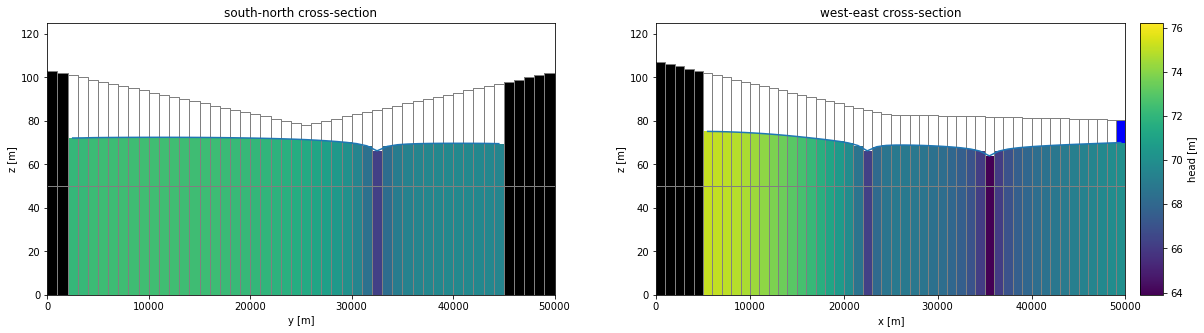

In [19]:
#Plot cross-section view of heads at center row and column:
col = 22   #column to plot cross-section along
row = 32   #row to plot cross-section along

f,ax = plt.subplots(1,2, figsize=(20,5))                                     #create empty figure and axes objects
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'Column': col})  #plot cross-section along given column (change column # to see different locations)
bc = xsec.plot_ibound()                                                      #plot boundary conditions
h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)  #plot heads as an array, with color range set by min and max of full array
ax[0].plot(np.arange(delr/2,Ly,delr), head_mx[0,:,col])                            #plots heads as a line
g  = xsec.plot_grid()                                                        #plot model grid
ax[0].set_xlabel('y [m]')
ax[0].set_ylabel('z [m]')
ax[0].set_title('south-north cross-section')

xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': row})      #plot cross-ection along given row
bc = xsec.plot_ibound()                                                      #plot boundary conditions
h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)   #plot heads as array with same color range as above
ax[1].plot(np.arange(delc/2,Lx,delc), head_mx[0,row,:])                            #plots heads as a line
g  = xsec.plot_grid()                                                        #plot grid
ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('z [m]')
ax[1].set_title('west-east cross-section')

#Add colorbar:
divider = make_axes_locatable(ax[1])                     #make axes dividable (to add colorbar)
cax = divider.append_axes('right', size="5%", pad=0.2)   #add an axis at the bottom for the colorbar
c = plt.colorbar(h, cax=cax, orientation='vertical')     #plot the colorbar
c.set_label('head [m]')                                  #label the colorbar

Text(0, 0.5, 'y [m]')

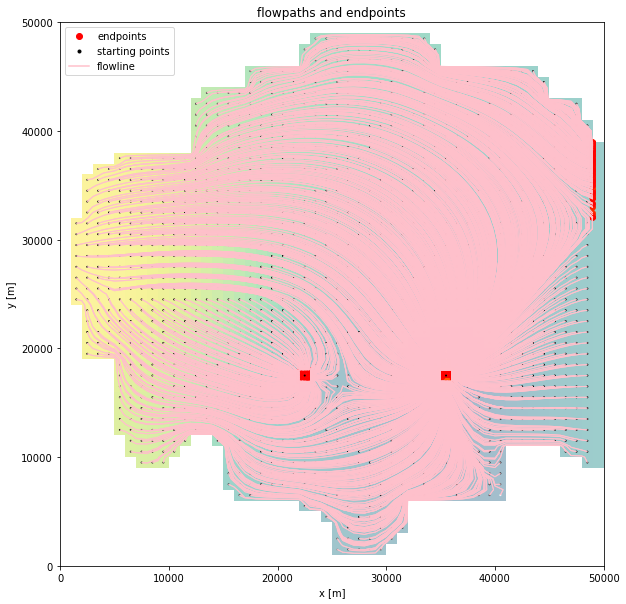

In [20]:
#Plot flowpath and endpoints:

f,ax = plt.subplots(1,1, figsize=(10, 10))              #make new figure and axes
ax.set_title('flowpaths and endpoints')
maps = flopy.plot.PlotMapView(model=mf)                 #make map object
h = maps.plot_array(head, masked_values=[-999.99], alpha=0.25) #plot heads as colors
#f = maps.plot_vector(frf, fff)                                #uncomment to plot vectors of flow direction in each cell
l = maps.plot_pathline(plines, layer=0, colors='pink', lw=1)   #uncomment to plot flowlines
e = maps.plot_endpoint(ept, cmap='autumn', s=5)                #plot endpoints of particles
e = maps.plot_endpoint(ept, direction='starting', cmap='binary_r', s=1)  #plot starting points of particles

plt.legend(handles=[matplotlib.lines.Line2D([],[], color='red', marker='o', linestyle='None', label='endpoints'),
                    matplotlib.lines.Line2D([],[], color='black', marker='.', linestyle='None', label='starting points'),
                    matplotlib.lines.Line2D([],[], color='pink',label='flowline')]) #add legend manually
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

Text(0.5, 1.0, 'west-east cross-section')

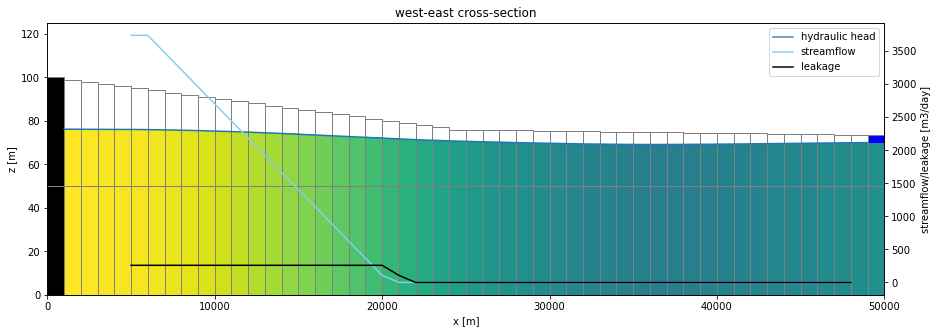

In [21]:
#Plot streamflow and leakage along stream:

#Extract streamflow & leakage data
strflows = np.zeros((nreach))       #create array of zeros the length of the stream
strleaks = np.zeros((nreach))       #create array of zeros the length of the stream
for i in np.arange(nreach):         #iterate over each reach
    strflows[i] = stf[i][1]         #get flow from stf array
    strleaks[i] = stl[i][1]         #get leakage from stl array

#Create figure & plot data:
f,ax = plt.subplots(1,1,figsize=(15,5))                                   #create figure object of width 15 in and height 5 in, with one subplot axis
xsec = flopy.plot.PlotCrossSection(model=mf, ax=ax, line={'Row': str_row})     #plot cross-ection along given row
bc = xsec.plot_ibound()                                                   #plot boundary conditions
h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)   #plot heads as array with same color range as above
hl = ax.plot(np.arange(0,Lx,delc), head_mx[0,str_row,:])                  #plots heads as a line
g  = xsec.plot_grid()                                                     #plot grid
ax2 = ax.twinx()                                                          #add a secondary y axis
f = ax2.plot(str_cols*delc, strflows, c='skyblue', label='streamflow')    #plot flows in each stream cell on second y axis
l = ax2.plot(str_cols*delc, strleaks, c='black', label='leakage')         #plot flows in each stream cell on second y axis

#Formatting:
plt.legend(handles=[matplotlib.lines.Line2D([],[], color='steelblue', label='hydraulic head'),
                    matplotlib.lines.Line2D([],[], color='skyblue', label='streamflow'),
                    matplotlib.lines.Line2D([],[], color='black', label='leakage')]) #add legend manually

ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax2.set_ylabel('streamflow/leakage [m3/day]')     #label second y axis
ax.set_title('west-east cross-section')


### Exports

In [184]:
np.savetxt('head_layer0.csv', head[0,:,:], delimiter=',')
np.savetxt('head_layer1.csv', head[1,:,:], delimiter=',')
sim =np.transpose([str_cols*delc, strflows])
np.savetxt('streamflows.csv', sim, delimiter=',')